In [6]:
# https://github.com/ultralytics/ultralytics/issues/1429#issuecomment-1519239409

from pathlib import Path
import torch
import argparse
import numpy as np
import cv2
from types import SimpleNamespace

from boxmot.tracker_zoo import create_tracker
from boxmot.utils import ROOT, WEIGHTS
from boxmot.utils.checks import TestRequirements
from boxmot.utils import logger as LOGGER
from boxmot.utils.torch_utils import select_device

tr = TestRequirements()
tr.check_packages(('ultralytics',))  # install
%load_ext autoreload
%autoreload 2
from ultralytics.yolo.engine.model import YOLO, TASK_MAP

from ultralytics.yolo.utils import SETTINGS, colorstr, ops, is_git_dir, IterableSimpleNamespace
from ultralytics.yolo.utils.checks import check_imgsz, print_args
from ultralytics.yolo.utils.files import increment_path
from ultralytics.yolo.engine.results import Boxes
from ultralytics.yolo.data.utils import VID_FORMATS
from ultralytics.yolo.utils.plotting import save_one_box

from multi_yolo_backend import MultiYolo
from utils import write_MOT_results


def on_predict_start(predictor):
    predictor.trackers = []
    predictor.tracker_outputs = [None] * predictor.dataset.bs
    predictor.args.tracking_config = \
        ROOT /\
        'boxmot' /\
        'deepocsort' /\
        'configs' /\
        ('deepocsort' + '.yaml')
    for i in range(predictor.dataset.bs):
        tracker = create_tracker(
            predictor.args.tracking_method,
            predictor.args.tracking_config,
            predictor.args.reid_model,
            predictor.device,
            predictor.args.half
        )
        predictor.trackers.append(tracker)




def parse_opt(yolo_model=WEIGHTS / 'yolov8n.pt', reid_model=WEIGHTS / 'mobilenetv2_x1_4_dukemtmcreid.pt',
              tracking_method='deepocsort', source='aiworkspace.jpg', imgsz=[640], conf=0.5, iou=0.7, device='', show=False,
              save=False, classes=None, project=ROOT / 'runs' / 'track', name='exp', exist_ok=False, half=False,
              vid_stride=1, hide_label=False, hide_conf=False, save_txt=False, save_id_crops=False, save_mot=False):
    opt = argparse.Namespace(
        yolo_model=yolo_model,
        reid_model=reid_model,
        tracking_method=tracking_method,
        source=source,
        imgsz=imgsz,
        conf=conf,
        iou=iou,
        device=device,
        show=show,
        save=save,
        classes=classes,
        project=project,
        name=name,
        exist_ok=exist_ok,
        half=half,
        vid_stride=vid_stride,
        hide_label=hide_label,
        hide_conf=hide_conf,
        save_txt=save_txt,
        save_id_crops=save_id_crops,
        save_mot=save_mot
    )
    return opt



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:

from ultralytics import yolo
args = {'yolo_model': 'yolov8n', 'reid_model': Path('/home/juma/code/luqmon_tracking/examples/weights/mobilenetv2_x1_4_dukemtmcreid.pt'), 'tracking_method': 'deepocsort', 'source': '/home/juma/code/luqmon_tracking/examples/aiworkspace.jpg',
        'imgsz': [640], 'conf': 0.5, 'iou': 0.7, 'device': '', 'show': True, 'save': False, 'classes': None, 'project': '/home/juma/code/luqmon_tracking/runs/track', 'name': 'exp', 'exist_ok': False, 'half': False, 'vid_stride': 1, 'hide_label': False, 'hide_conf': False, 'save_txt': False, 'save_id_crops': False, 'save_mot': False}

model = YOLO(args['yolo_model'] if 'v8' in str(
    args['yolo_model']) else 'yolov8n')
overrides = model.overrides.copy()
model.predictor = yolo.v8.detect.DetectionPredictor(
    overrides=overrides, _callbacks=model.callbacks)

# extract task predictor
predictor = model.predictor

# combine default predictor args with custom, preferring custom
combined_args = {**predictor.args.__dict__, **args}
# overwrite default args
predictor.args = IterableSimpleNamespace(**combined_args)
predictor.args.device = select_device(args['device'])


# setup source and model
if not predictor.model:
    predictor.setup_model(model=model.model, verbose=False)
predictor.setup_source(predictor.args.source)

predictor.args.imgsz = check_imgsz(
    predictor.args.imgsz, stride=model.model.stride, min_dim=2)  # check image size
predictor.save_dir = increment_path(Path(
    predictor.args.project) / predictor.args.name, exist_ok=predictor.args.exist_ok)

# Check if save_dir/ label file exists
if predictor.args.save or predictor.args.save_txt:
    (predictor.save_dir / 'labels' if predictor.args.save_txt else predictor.save_dir).mkdir(parents=True, exist_ok=True)
# Warmup model
if not predictor.done_warmup:
    predictor.model.warmup(imgsz=(
        1 if predictor.model.pt or predictor.model.triton else predictor.dataset.bs, 3, *predictor.imgsz))
    predictor.done_warmup = True
predictor.seen, predictor.windows, predictor.batch, predictor.profilers = 0, [
], None, (ops.Profile(), ops.Profile(), ops.Profile(), ops.Profile())
predictor.add_callback('on_predict_start', on_predict_start)
predictor.run_callbacks('on_predict_start')
model = MultiYolo(
    model=model.predictor.model if 'v8' in str(
        args['yolo_model']) else args['yolo_model'],
    device=predictor.device,
    args=predictor.args
)
for frame_idx, batch in enumerate(predictor.dataset):
    predictor.run_callbacks('on_predict_batch_start')
    predictor.batch = batch
    path, im0s, vid_cap, s = batch
    visualize = increment_path(save_dir / Path(path[0]).stem, exist_ok=True, mkdir=True) if predictor.args.visualize and (
        not predictor.dataset.source_type.tensor) else False

    n = len(im0s)
    predictor.results = [None] * n

    # Preprocess
    with predictor.profilers[0]:
        im = predictor.preprocess(im0s)

    # Inference
    with predictor.profilers[1]:
        preds = model(im, im0s)  # MODIFIED to return FeatureMap

    # Postprocess moved to MultiYolo
    with predictor.profilers[2]:
        predictor.results = model.postprocess(
            path, preds, im, im0s, predictor)  # MODIFIED to return FeatureMapBBoxes

2023-07-08 11:06:05.510 | INFO     | boxmot.utils.torch_utils:select_device:52 - Yolo Tracking v10.0.15 🚀 Python-3.10.6 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce RTX 3090, 24226MiB)



2023-07-08 11:06:05.604 | SUCCESS  | boxmot.deep.reid_model_factory:load_pretrained_weights:229 - Successfully loaded pretrained weights from "/home/juma/code/luqmon_tracking/examples/weights/mobilenetv2_x1_4_dukemtmcreid.pt"
2023-07-08 11:06:05.604 | WARNING  | boxmot.deep.reid_model_factory:load_pretrained_weights:233 - The following layers are discarded due to unmatched keys or layer size: ('classifier.weight', 'classifier.bias')


Initialize the Results class.


In [8]:
feature_map = preds[2]
feature_map.shape

torch.Size([1, 16, 160, 320])

In [9]:
predictor.results[0].boxes.boxes

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


tensor([[3.9286e+02, 7.2863e+02, 1.0793e+03, 1.1929e+03, 8.4564e-01, 5.6000e+01],
        [1.5949e+03, 4.2307e+02, 1.7377e+03, 5.9008e+02, 7.3887e-01, 5.8000e+01],
        [1.0671e+03, 6.3826e+02, 1.4370e+03, 9.7523e+02, 7.0748e-01, 5.6000e+01],
        [1.7339e+03, 4.1452e+02, 1.8521e+03, 5.5681e+02, 5.0617e-01, 5.8000e+01]], device='cuda:0')

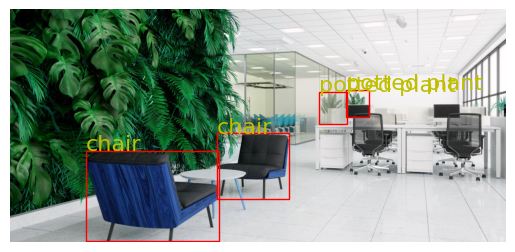

In [11]:
# Define the bounding box coordinates
import matplotlib.patches as patches
from matplotlib import pyplot as plt

# Create a figure and axes
fig, ax = plt.subplots(1)
ax.imshow(im0s[0])

boxes = [[392.85, 728.63, 1079.4, 1192.9],
         [1594.9, 423.06, 1737.7, 590.08],
         [1067.1, 638.26, 1437.0, 975.21],
         [1733.9, 414.50, 1852.1, 556.82]]
class_ids = [56, 58, 56, 58]
class_labels = [predictor.results[0].names[i] for i in class_ids]

# Plot the bounding boxes with class labels
for box, label in zip(boxes, class_labels):
    x_min, y_min, x_max, y_max = box[:4]
    width = x_max - x_min
    height = y_max - y_min
    rect = patches.Rectangle(
        (x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x_min, y_min, str(label), color='y', fontsize=16)

# Display the image with bounding boxes
plt.axis('off')
plt.show()

In [12]:

feature_map_boxes = predictor.results[0].feature_map_boxes[0]
print(feature_map_boxes.shape)
feature_map_boxes

torch.Size([4, 6])


tensor([[ 49.1070,  96.0790, 134.9178, 154.1118,   0.8456,  56.0000],
        [199.3635,  57.8836, 217.2095,  78.7597,   0.7389,  58.0000],
        [133.3832,  84.7821, 179.6260, 126.9033,   0.7075,  56.0000],
        [216.7353,  56.8148, 231.5104,  74.6017,   0.5062,  58.0000]], device='cuda:0')

In [13]:
x_min, y_min, x_max, y_max = 49,  96, 135, 154
chair1 = feature_map[0, :, y_min:y_max, x_min:x_max].mean(dim=(1, 2))
chair1.shape

torch.Size([16])

In [14]:
x_min, y_min, x_max, y_max = 133,  85, 180, 127
chair2 = feature_map[0, :, y_min:y_max, x_min:x_max].mean(dim=(1, 2))
chair2.shape

torch.Size([16])

In [15]:
x_min, y_min, x_max, y_max = 199,  58, 217,  79
plant1 = feature_map[0, :, y_min:y_max, x_min:x_max].mean(dim=(1, 2))
plant1.shape

torch.Size([16])

In [16]:
x_min, y_min, x_max, y_max = 217,  57, 232,  75
plant2 = feature_map[0, :, y_min:y_max, x_min:x_max].mean(dim=(1, 2))
plant2.shape

torch.Size([16])

In [17]:
torch.norm(chair1 - chair2)

tensor(2.0569, device='cuda:0')

In [18]:
torch.norm(chair1 - plant2)

tensor(3.4127, device='cuda:0')

In [19]:
torch.norm(chair1 - plant1)

tensor(3.6621, device='cuda:0')

In [20]:
torch.norm(plant2 - plant1)

tensor(2.3483, device='cuda:0')

# Same object distance
